# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv

In [21]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [149]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [4]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_diner, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [5]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_89640/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [6]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")
full_csv

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
1,Sunshine,alexr89@hotmail.fr,Sunshine,Renie,no,no,,,,,...,,,,,,,,,,
2,Hortish,hortensevincotte@gmail.com,Hortish,de Brouwer,no,no,,,,,...,,,,,,,,,,
3,MV,mvlvputbus@gmail.com,MV,d'Ursel,no,no,,,,,...,,,,,,,,,,
4,Pierre,pietdel@gmail.com,Pierre,Delacroix,no,no,,,,,...,,,,,,,,,,
5,Nabs,avanvolsem@hotmail.com,Nabs,Vanvo,no,no,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Tanine,tanine.daryoush@gmail.com,Tanine,,no,no,,,,,...,,,,,,,,,,
218,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,,,,,...,,,,,,,,,,
219,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,,,,,...,,,,,,,,,,
220,Nikou,nikou.kh03@gmail.com,Nikou,,no,no,,,,,...,,,,,,,,,,


# Double check the plusones to include them

In [7]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones

,name,email,plusones
11,Erica,erica.efst@gmail.com,Anastasis Amoratis
12,Caroline,carolinewvh@gmail.com,leonore.vehmeijer@gmail.com
17,Juju,jvanvolsem@gmail.com,Pietdel
35,Catalina,catalina.de.schrevel@hotmail.com,Hadrien Amiel
36,Adri,amiel.hadrien@gmail.com,Catalina De Schrevel
39,Frinch,thomvincotte@hotmail.com,Emily van Wassenhove
61,Sam,sam.rz@hotmail.com,Camille Testard
69,Molly,ohman.molly@gmail.com,Sammie Katt- but he's also answering now haha
81,Anne Sophie,annesophievv@hotmail.com,Steven Vriesendorp
100,Alice,alice.j.sommer@gmail.com,Edzi


# Load additional information

In [8]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')
additional

,email,Sex,friend_of,table
0,victor.stinglhamber@gmail.com,male,m,1.0
1,bertichat@gmail.com,male,m,1.0
2,fdelimburg@gmail.com,male,m,1.0
3,jdursel@gmail.com,male,m,1.0
4,harold.loop@gmail.com,male,m,1.0
...,...,...,...,...
219,dehemptinneb@gmail.com,male,p,NaN
220,ami@dg.com,female,m,NaN
221,chdelachapelle@gmail.com,male,p,NaN
222,margueritesvo@me.com,female,p,NaN


# People from who we dont have information

In [9]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'plusone_phillipe'}

In [10]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [11]:
answered_invitation_but_didnt_play = full_csv[full_csv['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
58,Chachaa,vandenbulcke.cha@gmail.com,Chachaa,Van den Bulcke,yes,yes,,,,,...,,,,,,,,,,
62,Mams,azinedeh@gmail.com,Mams,de Hemptinne,yes,yes,,,,,...,,,,,,,,,,
103,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,,,,,...,,,,,,,,,,
155,Jozzz,jdursel@gmail.com,Jozzz,d'Ursel,yes,yes,,,,,...,,,,,,,,,,
163,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,,,,,...,,,,,,,,,,
218,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,,,,,...,,,,,,,,,,


# All people who at least started the table seating game

In [12]:
only_answered = full_csv[full_csv["seating_question_1"].str.strip() != ""]
only_answered

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
11,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,Anastasis Amoratis,01_salt,02_squirtle,03_gryffondor,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
12,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,yes,leonore.vehmeijer@gmail.com,01_paprika,02_squirtle,03_huffelpuf,...,06_ghost,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
14,Constance,c.carak@gmail.com,Constance,Gerard,yes,yes,,01_salt,02_squirtle,03_gryffondor,...,06_nessie,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
15,Fransozich,fdelimburg@gmail.com,Fransozich,de Limburg Stirum,yes,yes,,01_salt,02_bulbasaur,03_gryffondor,...,06_nessie,07_pistachio,08_spices,09_unitedkingdom,10_love_liv,,,,,
16,Isa,isalinebaudry@hotmail.com,Isa,Baudry,yes,yes,,01_paprika,02_charmander,03_gryffondor,...,06_god,07_pistachio,08_sex,09_france,10_love_math,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Claire,devries.cee@gmail.com,Claire,de Vries,yes,yes,,01_salt,02_charmander,03_ravenclaw,...,06_god,07_pepper,08_sex,09_unitedkingdom,10_love_liv,,,,,
212,Pouzeee & Tom,paulineranscelot@gmail.com,Pouzeee & Tom,Ranscelot Cartuyvels,yes,yes,,01_paprika,02_charmander,03_huffelpuf,...,06_nessie,07_pistachio,08_sex,09_france,10_love_liv,,,,,
213,Arthur,adansembourg@freeler.nl,Arthur,,yes,yes,ellenkrol@alzo.nl,01_salt,02_squirtle,03_ravenclaw,...,06_god,07_pistachio,08_sex,09_netherlands,10_love_liv,,,,,
214,Aline Tatiana,alinefadie@gmail.com,Aline Tatiana,Fadié,yes,yes,,01_salt,02_charmander,03_slitherin,...,06_ghost,07_chocolate,08_icecream,09_france,10_love_math,,,,,


# Weird group who played but answered no for dinner

In [13]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_diner,plusones,seating_question_1,seating_question_2,seating_question_3,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
63,Camille,camille.testard@protonmail.com,Camille,,no,no,,01_salt,02_charmander,03_gryffondor,...,06_ghost,07_chocolate,08_spices,09_france,10_love_math,,,,,
85,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,,01_salt,02_charmander,03_gryffondor,...,06_god,07_pistachio,08_sex,,,,,,,
116,Toutia,toutia.daryoush@gmail.com,Toutia,Daryoush,no,no,,01_salt,02_charmander,03_ravenclaw,...,06_aliens,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,
148,Amelie,ami@dg.com,Amelie,,yes,no,Livia,01_paprika,02_bulbasaur,03_huffelpuf,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
162,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,,01_salt,02_charmander,03_ravenclaw,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,
169,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,,01_salt,02_charmander,03_gryffondor,...,06_aliens,07_chocolate,08_spices,09_unitedkingdom,10_love_liv,,,,,
176,Papili,thdeguerre@gmail.com,Papili,de Guerre,yes,no,anastasiadeguerre@gmail.com,01_salt,02_bulbasaur,03_gryffondor,...,06_nessie,07_chocolate,08_sex,09_france,10_love_liv,,,,,
205,Olivier,odeguerre@free.fr,Olivier,,yes,no,,01_paprika,02_squirtle,03_huffelpuf,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,


In [14]:
len(only_answered)

88

# Only seating questions to encode

In [135]:
only_seating_colls = only_answered[["seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)
only_seating_colls

/tmp/ipykernel_89640/1183379475.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
11,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
12,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
14,salt,squirtle,gryffondor,browncafe,wine,nessie,chocolate,icecream,unitedkingdom,math
15,salt,bulbasaur,gryffondor,clubbing,wine,nessie,pistachio,spices,unitedkingdom,liv
16,paprika,charmander,gryffondor,clubbing,wine,god,pistachio,sex,france,math
...,...,...,...,...,...,...,...,...,...,...
211,salt,charmander,ravenclaw,browncafe,wine,god,pepper,sex,unitedkingdom,liv
212,paprika,charmander,huffelpuf,clubbing,gin,nessie,pistachio,sex,france,liv
213,salt,squirtle,ravenclaw,browncafe,wine,god,pistachio,sex,netherlands,liv
214,salt,charmander,slitherin,clubbing,coffee,ghost,chocolate,icecream,france,math


In [136]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
69,Molly,ohman.molly@gmail.com,salt,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer
85,Aad,adriaanvanberckel2009@hotmail.com,salt,charmander,gryffondor,clubbing,tea,god,pistachio,sex,no answer,no answer
152,Ananas,anastasiadeguerre@gmail.com,paprika,bulbasaur,slitherin,browncafe,beer,nessie,chocolate,icecream,germany,no answer
179,Olga,odeborchgrave@gmail.com,salt,bulbasaur,no answer,no answer,no answer,no answer,no answer,no answer,no answer,no answer
200,Monique,costepia@gmail.com,salt,squirtle,gryffondor,clubbing,tea,god,chocolate,icecream,no answer,no answer


In [137]:
filtered_df = only_seating_colls[~mask]
filtered_df

,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
11,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
12,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
14,salt,squirtle,gryffondor,browncafe,wine,nessie,chocolate,icecream,unitedkingdom,math
15,salt,bulbasaur,gryffondor,clubbing,wine,nessie,pistachio,spices,unitedkingdom,liv
16,paprika,charmander,gryffondor,clubbing,wine,god,pistachio,sex,france,math
...,...,...,...,...,...,...,...,...,...,...
211,salt,charmander,ravenclaw,browncafe,wine,god,pepper,sex,unitedkingdom,liv
212,paprika,charmander,huffelpuf,clubbing,gin,nessie,pistachio,sex,france,liv
213,salt,squirtle,ravenclaw,browncafe,wine,god,pistachio,sex,netherlands,liv
214,salt,charmander,slitherin,clubbing,coffee,ghost,chocolate,icecream,france,math


In [138]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [139]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

In [140]:
one_hot_encoded

,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,seating_question_3_slitherin,seating_question_4_browncafe,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
79,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
80,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
81,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Weight the different questions differently

In [199]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

nr_features = {
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 2,
}

weigths = {
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [200]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,seating_question_3_slitherin,seating_question_4_browncafe,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.771589,0.771589,-1.894445,-3.389288,5.330320,4.113393,-1.759240,-1.551405,-1.894445,1.749286,...,1.518182,-0.872982,-0.872982,-0.392837,-2.242136,-0.697863,-0.977170,3.600411,0.752355,-0.752355
1,0.829458,-0.829458,-1.894445,-3.389288,5.330320,-3.150684,7.366817,-1.551405,-1.894445,-2.521029,...,1.518182,-0.872982,-0.872982,-0.392837,-2.242136,-0.697863,-0.977170,3.600411,-1.329160,1.329160
2,-0.771589,0.771589,-1.894445,-3.389288,5.330320,4.113393,-1.759240,-1.551405,-1.894445,1.749286,...,1.518182,-0.872982,-0.872982,-0.392837,-2.242136,-0.697863,-0.977170,3.600411,-1.329160,1.329160
3,-0.771589,0.771589,6.841053,-3.389288,-2.431374,4.113393,-1.759240,-1.551405,-1.894445,-2.521029,...,-1.482035,-0.872982,2.577374,-0.392837,-2.242136,-0.697863,-0.977170,3.600411,0.752355,-0.752355
4,0.829458,-0.829458,-1.894445,3.823812,-2.431374,4.113393,-1.759240,-1.551405,-1.894445,-2.521029,...,-1.482035,2.577374,-0.872982,-0.392837,2.787520,-0.697863,-0.977170,-1.735913,-1.329160,1.329160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-0.771589,0.771589,-1.894445,3.823812,-2.431374,-3.150684,-1.759240,8.353719,-1.894445,1.749286,...,-1.482035,2.577374,-0.872982,-0.392837,-2.242136,-0.697863,-0.977170,3.600411,0.752355,-0.752355
79,0.829458,-0.829458,-1.894445,3.823812,-2.431374,-3.150684,7.366817,-1.551405,-1.894445,-2.521029,...,-1.482035,2.577374,-0.872982,-0.392837,2.787520,-0.697863,-0.977170,-1.735913,0.752355,-0.752355
80,-0.771589,0.771589,-1.894445,-3.389288,5.330320,-3.150684,-1.759240,8.353719,-1.894445,1.749286,...,-1.482035,2.577374,-0.872982,-0.392837,-2.242136,-0.697863,6.396021,-1.735913,0.752355,-0.752355
81,-0.771589,0.771589,-1.894445,3.823812,-2.431374,-3.150684,-1.759240,-1.551405,6.841053,-2.521029,...,1.518182,-0.872982,-0.872982,-0.392837,2.787520,-0.697863,-0.977170,-1.735913,-1.329160,1.329160


# Run PCA

In [201]:
pca = PCA(n_components=2)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

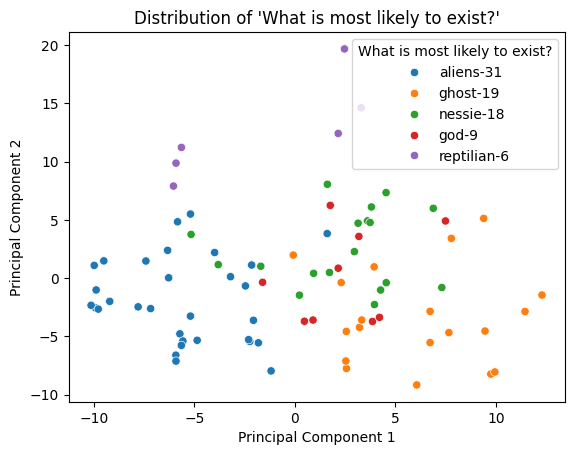

In [205]:
current_question = "seating_question_6"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Run UMAP